In [ ]:
# ! pip install --user --upgrade scipy numba
# ! pip install --user psutil
# ! pip install --user statsmodels

In [1]:
import os

os.environ['NUMBA_DISABLE_JIT'] = '1'

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import seaborn as sns
from joblib import Parallel, delayed

from trees import TransferTreeRegressor, build_tree, Node, collect_score
from simulation import generate_data, split_out_dat
from criteria import mse, transfer, causal_tree_criterion


import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [14, 2.5]

In [3]:
from trees import Leaf
leaf = Leaf(0,0,0,0)

def plot_split(node, X, tau, context_idxs):
    idx = X[:, node.dim] > node.thresh
    d = np.vstack([tau, idx, context_idxs]).T
    df = pd.DataFrame(d, columns = ['tau', 'split', 'ctx'])

    for _, d in df.groupby('split'):
        v = d.groupby('ctx').mean().tau.values
        print(d.groupby('ctx').mean().tau.values)
    # sns.distplot(df)
    g = sns.FacetGrid(df, row = 'split', hue = 'ctx', aspect=5.0)
    g.map(sns.distplot, 'tau', bins=10, kde=False)
    plt.legend()

In [4]:
from sklearn.metrics import mean_squared_error, r2_score
from simulation import Dataset
from collections import namedtuple
from copy import deepcopy

Results = namedtuple('Results', ['mse', 'r2', 'r2t', 'predictions', 'data', 'model', 'model_name'])

def fit_model(model, dat: Dataset):
    model_name, model, fit_fn = model
    model = deepcopy(model)
    model.fit(**fit_fn(dat))

    preds = model.predict(dat.phi.target, 0.95)

    mse = mean_squared_error(dat.tau.target, preds[:, 0])
    r2 = r2_score(dat.tau.target, preds[:, 0])    

    r2t = 1 - (mse / np.mean((dat.tau.target - np.mean(dat.tau.source))**2))

    return Results(mse, r2, r2t, preds, dat, model, model_name)

In [5]:
import pandas as pd

def stats_df(dat):
    return pd.DataFrame(dat, columns=['value', 'model'])

def pipe(*fns):
    def fn(res):
        for f in fns:
            res = f(res)
        return res
    return lambda f: lambda *a, **k: fn(f(*a, **k))

def plot_dist(df, **kwargs):
    for model, df in df.groupby('model'):
        sns.distplot(df.value, label=model, **kwargs)
    plt.legend()
    plt.show()


def _get_within_ci(preds, taus):
    return pd.DataFrame(preds, columns = ['pred', 'lower', 'upper']) \
             .assign(true = taus) \
             .groupby('pred') \
             .apply(lambda df: df.assign(true_cate = df.true.mean())) \
             .pipe(lambda df: df.assign(within_int = \
                                        (df.true_cate <= df.upper) & \
                                        (df.true_cate >= df.lower))) \
             .pipe(lambda df: df['within_int'].sum() / df.shape[0])


@pipe(stats_df)
def compare(fn, baseline, vals):
    comp = lambda a,b: (a-b)/b

    bs = [fn(m) for v in vals for m in v if m.model_name == baseline]

    return [(comp(fn(m), b), m.model_name)
            for v, b in zip(vals, bs)
            for m in v
            if m.model_name != baseline]


# pick


def r_squared(results):
    tau_var = lambda r: np.mean((np.mean(r.data.tau.target) - r.data.tau.target)**2)
    return pick(lambda m: 1 - m.mse/tau_var(m), results)

def plot_and_print(df, **kwargs):
    plot_dist(df, **kwargs)
    print(df.groupby('model').mean())

def runrun(models, params):
    dat = generate_data(**{**params(), 'plot': False})
    dat = split_out_dat(dat)
    return [fit_model(model, dat) for model in models]

def data_check(params):
    generate_data(**{**params, 'plot': True})

def compare_feature_importance(model):
    a, b = model.feature_importance(gain=False)
    return a / (a + b)

def rezz(r):
    return {
        'r2': r.r2,
        'r2t': r.r2t,
        'mse': r.mse,
        'tree-size': len(r.model.tree),
        'V-importance': compare_feature_importance(r.model),
        'CI-coverage': _get_within_ci(r.predictions, r.data.tau.target)
    }


def format_results(results):    
    r = [{'fn': fn, 'dgp':dgp, 'model': r.model_name, **rezz(r)} 
               for fn, dgp, res in results for r in res]    

    return pd.DataFrame(r)

from statsmodels.iolib.summary2 import _df_to_simpletable, _formatter

def print_table(d):
    table = _df_to_simpletable(d, float_format="%.2f", index=False)
    s = table.as_latex_tabular()
    print(s)

In [6]:
# ys, Xs, taus = zip(*dat)
# from sklearn.linear_model import LinearRegression

# LinearRegression().fit(Xs[0], ys[0]).coef_, LinearRegression().fit(Xs[1], ys[1]).coef_, LinearRegression().fit(Xs[2], ys[2]).coef_, LinearRegression().fit(Xs[3], ys[3]).coef_

# for d in [LinearRegression().fit(Xs[i], taus[i]).coef_ for i in range(4)]:
#     print(d)

# for d in [LinearRegression(fit_intercept=True).fit(Xs[i][:, 1:3], taus[i]).predict(Xs[0][:, 1:3]) for i in range(4)]:
#     sns.scatterplot(Xs[0][:, 1], d, alpha=0.3)

In [15]:
transfer_best = TransferTreeRegressor(criterion = transfer, 
                                      max_depth = 7, 
                                      min_samples_leaf = 50,
                                      alpha = None)

transfer_base = lambda dat: ({'X': dat.phi.source, 
                              'y': dat.y.source, 
                              'treatment': dat.treatment,
                              'context_idxs': dat.context_idxs, 
                              'target_X': dat.phi.target,
                              'min_samples': 25,
                              'honest': True})

models = [
    # ('TTT', 
    #  transfer_best,
    #  lambda dat: ({**transfer_base(dat), 
    #                'xp_version': 7,
    #                'prediction_mode': 1,
    #                'importance': False})),

    # ('TTT-MI', 
    #  transfer_best,
    #  lambda dat: ({**transfer_base(dat), 
    #                'xp_version': 9,
    #                'prediction_mode': 1,
    #                'importance': True})),

    # ('TTT-M', 
    #  transfer_best,
    #  lambda dat: ({**transfer_base(dat), 
    #                'xp_version': 6,
    #                'prediction_mode': 1,
    #                'importance': False})),

    # ('TTT', 
    #  transfer_best,
    #  lambda dat: ({**transfer_base(dat), 
    #                'xp_version': 8,
    #                'prediction_mode': 1,
    #                'importance': False})),

    ('TTT-I', 
     transfer_best,
     lambda dat: ({**transfer_base(dat), 
                   'xp_version': 8,
                   'prediction_mode': 1,
                   'importance': True})),

    ('TTT-M', 
     transfer_best,
     lambda dat: ({**transfer_base(dat), 
                   'xp_version': 9,
                   'prediction_mode': 1,
                   'importance': False})),

    ('CT',
     TransferTreeRegressor(criterion = causal_tree_criterion, 
                           max_depth = 7, 
                           min_samples_leaf = 50,
                           alpha = None),

     lambda dat: ({'X': dat.phi.source,
                   'y': dat.y.source, 
                   'treatment': dat.treatment,
                   'min_samples': 25,
                   'honest': True,
                   'var_weight': 0.5})),
]




In [ ]:
data_check({**gen_params(1000, 4), 'fn': FUNCTIONS['nl-hard']})

In [16]:
%%time

from scipy.stats import invgamma

def gen_params(N, K):
    ps = { 'hiddens': [(0,2)]*K,
           'hidden_cause': True,
           'N': N,
           'v_conds': list(zip(*(np.random.uniform(low=-2, high=2, size=K),
                            np.random.uniform(low=-4, high=6, size=K),
                            invgamma.rvs(20, scale=10, size=K)))),

           'z_conds': list(zip(*(np.random.uniform(low=-2, high=4, size=K),
                                 invgamma.rvs(20, scale=30, size=K)))) 
    }

    return ps


def param_group(fn, K): 
    return [
        ('UP', lambda: ({'fn': fn, **gen_params(1000, K)})),
        ('FS', lambda: ({'fn': fn, **gen_params(1000, K),
                  'v_conds': [(0.5,0,1)]*K,
                  'z_conds': [(2,2)]*K}))
    ]

# FUNCTIONS = {
#     'nl-hard': lambda h,v,z,w: -w*(h > 0).astype(int) + 0.5*w*(z > 0).astype(int) + np.random.normal(0, 0.25, size = h.shape[0]),
#     'nl-simple': lambda h,v,z,w: -w*(h > 0).astype(int) + w*(z > 0).astype(int) + np.random.normal(0, 0.1, size = h.shape[0]),
#     'linear': lambda h,v,z,w: -w*h + 0.5*w*z + np.random.normal(0, 0.1, size = h.shape[0])
# }


FUNCTIONS = {
    # 'nl-hard': lambda h,v,z,w: -w*(h > 0).astype(int) + 0.5*w*(z > 0).astype(int) + np.random.normal(0, 0.25, size = h.shape[0]),
    'nl-hard': lambda h,v,z,w: -w*h*(h > 0).astype(int) + 0.5*w*z*(z > 0).astype(int) + np.random.normal(0, 0.5, size = h.shape[0]),

    'nl-stacked': lambda h,v,z,w: \
    np.array([w*(h > i).astype(int) for i in range(-2,4,2)]).sum(axis=0) + \
    np.array([0.5*w*(z > i).astype(int) for i in range(-2,4,2)]).sum(axis=0) + \
    np.random.normal(0, 0.1, size = h.shape[0]),

    'nl-simple': lambda h,v,z,w: -w*(h > 0).astype(int) + w*(z > 0).astype(int) + np.random.normal(0, 0.1, size = h.shape[0]),
    'linear': lambda h,v,z,w: -w*h + 0.5*w*z + np.random.normal(0, 0.1, size = h.shape[0])
}


results = [(fn, pp, res)
           for fn, f in FUNCTIONS.items()
           for pp, params in param_group(f, 5)
           for res in Parallel(n_jobs=-1)(delayed(runrun)(models, params) for i in range(128))]

/home/jupyter/.local/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:703: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


CPU times: user 47.3 s, sys: 5.6 s, total: 52.9 s
Wall time: 12min 30s


In [17]:
df = format_results(results)

<ipython-input-5-b61cdf56cd78>:64: RuntimeWarning: invalid value encountered in double_scalars
  return a / (a + b)


In [91]:
# df.to_csv('results-1000-3-pooled.csv', index=False)

In [87]:
# df = pd.read_csv('results-1000-4-pooled-2.csv')

In [18]:
def get_measure(q, fn, df):
    d = fn(df.groupby(['model', 'dgp', 'fn']))
    d = d.unstack(level=[2,1]).reset_index()
    d.columns = d.columns.get_level_values(0)
    d.insert(0, 'measure', q)
    return d
# print_table(d)

measures = [
    ('r2t-0.1', lambda d: d.r2t.quantile(.1)),
    ('r2t-0.5', lambda d: d.r2t.quantile(.5)),
    ('r2t-0.9', lambda d: d.r2t.quantile(.9)),
    ('r2t-mean', lambda d: d.r2t.mean()),
    ('mse-mean', lambda d: d.mse.mean()),
    ('V-importance', lambda d: d['V-importance'].mean()),
    ('CI-coverage', lambda d: d['CI-coverage'].mean()),        
    ('tree-size', lambda d: d['tree-size'].mean()),        
]

print_table(pd.concat([get_measure(q, fn, df) for q, fn in measures]))

\begin{center}
\begin{tabular}{cccccccccc}
\hline
  measure    & model & linear & nl-hard & nl-simple & nl-stacked & linear & nl-hard & nl-simple & nl-stacked  \\
\hline
\hline
\end{tabular}
\begin{tabular}{rrrrrrrrrr}
     r2t-0.1 &    CT &   0.49 &    0.41 &      0.49 &       0.41 &  -1.08 &   -0.38 &     -0.12 &      -0.85  \\
     r2t-0.1 & TTT-I &   0.28 &    0.26 &      0.34 &       0.24 &  -1.40 &   -0.49 &     -0.02 &      -0.86  \\
     r2t-0.1 & TTT-M &   0.43 &    0.36 &      0.46 &       0.24 &  -0.38 &    0.03 &      0.25 &      -0.13  \\
     r2t-0.5 &    CT &   0.52 &    0.44 &      0.52 &       0.44 &  -0.02 &    0.14 &      0.29 &      -0.01  \\
     r2t-0.5 & TTT-I &   0.32 &    0.32 &      0.40 &       0.30 &   0.06 &    0.12 &      0.37 &       0.13  \\
     r2t-0.5 & TTT-M &   0.47 &    0.41 &      0.50 &       0.33 &   0.15 &    0.20 &      0.42 &       0.14  \\
     r2t-0.9 &    CT &   0.55 &    0.48 &      0.55 &       0.47 &   0.47 &    0.44 &      0.64 &      

In [79]:
def plot_dist(df, var, **kwargs):
    for model, d in df.groupby(['model']):
        sns.distplot(d[var], label=model, **kwargs)
    plt.legend()
    # plt.xlim(-1, 1)
    plt.show()




In [78]:
?sns.distplot

In [ ]:
plot_dist(df, 'r2t', bins=100, kde=False)

In [ ]:
plot_dist(df, 'CI-coverage', bins=100, kde=False)

In [165]:
%%time

params = lambda: ({
    'N': 1000,
    # 'fn': lambda h,v,z,w: -w*h*(h > 0).astype(int) + 0.5*w*z*(z > 0).astype(int) + np.random.normal(0, 0.25, size = h.shape[0]),
    # 'fn': lambda h,v,z,w: -w*h + \
    # np.array([0.5*w*(z > i).astype(int) for i in range(2)]).sum(axis=0) + \
    # np.random.normal(0, 0.5, size = h.shape[0]),

    # 'fn': lambda h,v,z,w: -w*(h > 0).astype(int) + w*(z > 0).astype(int) + np.random.normal(0, 0.01, size = h.shape[0]),
    # 'fn': lambda h,v,z,w: -w*h + 0.5*w*z + np.random.normal(0, 0.5, size = h.shape[0]),
    'fn': lambda h,v,z,w: -w*(h > 0).astype(int) + w*(z > 0).astype(int) + np.random.normal(0, 0.1, size = h.shape[0]),
    'hidden_cause': True,
    **gen_params(4)
})


results = Parallel(n_jobs=-1)(delayed(runrun)(models, params) for i in range(10))

CPU times: user 276 ms, sys: 4 ms, total: 280 ms
Wall time: 43.7 s


In [103]:
pick(lambda m: m.r2, results).groupby('model').quantile(.5)

,value
model,
causal-best-tree,0.191655
transfer-5-pm1,0.272921
transfer-5-pm1-importance,0.169742


In [ ]:
plot_and_print(compare(lambda d: d.mse, 'causal-best-tree', results), bins=20)
plot_and_print(r_squared(results))
plot_and_print(compare_cis(results))
plot_and_print(pick(lambda m: collect_score(m.model.tree), results))
plot_and_print(pick(lambda m: len(m.model.tree), results))
plot_and_print(pick(lambda d: d.model.feature_importance(gain=False)[1] / (d.model.feature_importance(gain=False)[0] + 1e-9), results))

In [ ]:
results[6][2].model.tree

# Causal Tree Test

In [55]:
from sklearn.model_selection import ParameterGrid
from copy import deepcopy

def make_nested_grid(params):
    return ParameterGrid({ key: list(ParameterGrid(value))
                           for key, value in params.items()})


def _crossval_score(model, X, y, treatment, weights, splitter, fit_params, init_params):
    model = deepcopy(model)
    model.set_params(**init_params)
    scores = []

    for train_idx, test_idx in splitter.split(X, treatment):
        model.fit(X[train_idx, :], 
                  y[train_idx], 
                  treatment = treatment[train_idx], 
                  sample_weight = weights[train_idx],
                  **fit_params)

        score = model.score(X[test_idx, :],
                            y[test_idx], 
                            treatment = treatment[test_idx], 
                            sample_weight = weights[test_idx],
                            **fit_params)
            
        scores.append(score)
    
    return np.mean(scores)

from joblib import Parallel, delayed

def model_search(model, X, y, treatment, weights, init_params, fit_params, splitter, n_jobs = -1):
    grid = make_nested_grid({'fit_params': fit_params, 
                             'init_params': init_params})

    all_scores = Parallel(n_jobs=n_jobs)(delayed(_crossval_score)(model, X, y, treatment, weights, splitter, **g) for g in grid)
    # all_scores = [_crossval_score(model, X, y, treatment, weights, splitter, **g) for g in grid]

    return list(zip(grid, all_scores))   

In [246]:
def eta(X):
    return 0.5 * X[:, 0] + X[:, 1]

def kappa(X):
    return 0.5 * X[:, 0]

def gen_y(X, w):
    return eta(X) + 0.5 * (2*w - 1) * kappa(X) + np.random.normal(0, 0.01)

N = 1000
S = round(N/2)
X = np.random.normal(0, 1, (N, 6))
treatment = np.random.binomial(1, 0.5, N)
y = gen_y(X, treatment)

In [247]:
# Dataset phi_source, phi_target (X)
# 

<function __main__.fit_model(model, dat: simulation.Dataset)>

In [74]:
from simulation import Dataset, Ctx

def eta(X):
    return 0.5 * np.sum(X[:, :2], axis=1) + np.sum(X[:, 2:], axis=1)

def kappa(X):
    return np.sum(X[:, :2] * (X[:, :2] > 0).astype(int), axis=1)

def gen_y(X, w):
    return eta(X) + 0.5 * (2*w - 1) * kappa(X) + np.random.normal(0, 0.5, size = X.shape[0])


def causal_trees_simulation(S, N):
    X = np.random.normal(0, 1, (N, 6))
    treatment = np.random.binomial(1, 0.5, N)
    weights = np.ones(N)
    taus = kappa(X)
    y = gen_y(X, treatment)

    split = lambda arr: (arr[:S], arr[S:])
    
    return Dataset(Ctx(*split(X)), Ctx(*split(y)), treatment[:S], np.zeros(S), Ctx(*split(taus)))


In [ ]:
sim_dat = pd.concat([pd.DataFrame(X, columns = range(1, 7)), 
                     pd.DataFrame({ 'y': y, 'treatment': treatment, 'tau': kappa(X)})], axis=1)

sim_dat.to_csv('sim_dat-2.csv', index=False)

In [376]:
# idx = np.arange(X.shape[0])
# np.random.shuffle(idx)

# treatment = treatment[idx]
# X = X[idx, :]
# y = y[idx]

In [ ]:
%%time

from sklearn.model_selection import StratifiedKFold
cv = StratifiedKFold(n_splits = 3)

model = TransferTreeRegressor(criterion = causal_tree_criterion, 
                              min_samples_leaf = 10,
                              alpha = 0.1, 
                              honest = False)

fit_params = {'min_samples': [25] }
init_params = {'alpha': [ -.1, -0.05, -0.01, 0.0, 0.01, 0.05, 0.1, 0.4 ], 'honest': [True] }

results = model_search(model, X[:S], y[:S], treatment[:S], weights[:S], init_params, fit_params, cv)

best_params = sorted(results, key = lambda t: t[1])[0][0]['init_params']

best_params

In [75]:
models = [
    ('causal-tree', 
     TransferTreeRegressor(criterion = causal_tree_criterion, 
                           min_samples_leaf = 50,
                           alpha = None),

     lambda dat: {'X': dat.phi.source, 
                  'y':dat.y.source, 
                  'treatment': dat.treatment, 
                  'min_samples': 25,
                  'honest': True,
                  'var_weight': 0.5}),

    ('causal-tree-no-var', 
     TransferTreeRegressor(criterion = causal_tree_criterion, 
                           min_samples_leaf = 50,
                           alpha = None),

     lambda dat: {'X': dat.phi.source, 
                  'y':dat.y.source, 
                  'treatment': dat.treatment, 
                  'min_samples': 25,
                  'honest': True,
                  'var_weight': 0.0}),

    # ('transfer-tree', 
    #  TransferTreeRegressor(criterion = transfer, 
    #                        min_samples_leaf = 50,
    #                        alpha = None),

    #  lambda dat: {'X': dat.phi.source, 
    #               'y': dat.y.source, 
    #               'treatment': dat.treatment, 
    #               'min_samples': 25,
    #               'honest': True,
    #               'var_weight': 0.5, 
    #               'context_idxs': dat.context_idxs, 
    #               'target_X': dat.phi.target, 
    #               'importance': False})   
]

In [76]:
def run_causal_trees(models, **params):
    data = causal_trees_simulation(**params)
    return [fit_model(model, data) for model in models]

In [89]:
params = { 'S': 500, 'N': 8000 }

results = Parallel(n_jobs=-1)(delayed(run_causal_trees)(models, **params) for i in range(100))

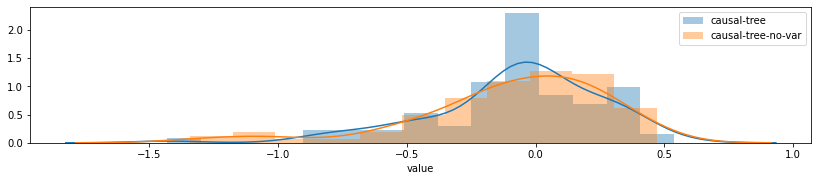

In [90]:
plot_dist(pick(lambda m: m.r2, results))

In [91]:
pick(lambda m: m.r2, results).groupby('model').quantile(.5)

,value
model,
causal-tree,-0.023311
causal-tree-no-var,-0.012264


In [92]:
pick(lambda m: m.r2, results).groupby('model').mean()

,value
model,
causal-tree,-0.075046
causal-tree-no-var,-0.092913


In [ ]:
model = TransferTreeRegressor(criterion = mse, max_depth = 5, min_samples_leaf = 10)

model.fit(phi(X), y, sample_weight = weights)
preds = model.predict(phi(X))
# np.mean((preds - y)**2)

np.histogram(preds)

In [60]:
from sklearn.tree import DecisionTreeRegressor
model = DecisionTreeRegressor(max_depth=5, min_samples_leaf=10)

model.fit(phi(X), y, sample_weight = weights)
preds = model.predict(phi(X))
np.mean((preds - y)**2)

(array([  15,    0,   41,   23,   95,   47,   87,  103,  406, 1183]),
 array([-129.40835129, -116.21549089, -103.02263049,  -89.82977009,
         -76.63690969,  -63.44404929,  -50.25118889,  -37.05832849,
         -23.86546809,  -10.67260769,    2.52025272]))

In [34]:
model = DecisionTreeRegressor(max_depth=4, min_samples_leaf=20)

np.mean(np.array([run_model(dat, model, phi, 0, 3, use_weights = None, model_search = True) for i in range(10)]), 0)

array([ 0.3661, 20.3762,  0.4404,  7.6768])

In [35]:
np.mean(np.array([run_model(dat, model, phi, 0, 3, use_weights = None, model_search = False) for i in range(10)]), 0)

array([ 0.3656, 41.3072, 15.5   ,  1.5563])

In [36]:
np.mean(np.array([run_model(dat, model, phi, 0, 3, use_weights = 1, model_search = True) for i in range(10)]), 0)

array([11.7473, 32.487 , 11.613 ,  4.5725])

In [37]:
np.mean(np.array([run_model(dat, model, phi, 0, 3, use_weights = 1, model_search = False) for i in range(10)]), 0)

array([12.42759, 25.75614,  5.67631,  3.50874])

In [38]:
model = TransferTreeRegressor(criterion=mse, max_depth=4, min_samples_leaf=20)

np.mean(np.array([run_model(dat, model, phi, 0, 3, use_weights = None, model_search = True) for i in range(10)]), 0)

array([ 0.3661, 20.3762,  0.4404,  7.6768])

In [39]:
np.mean(np.array([run_model(dat, model, phi, 0, 3, use_weights = None, model_search = False) for i in range(10)]), 0)

array([ 0.3656, 41.3072, 15.5   ,  1.5563])

In [52]:
np.mean(np.array([run_model(dat, model, phi, 0, 3, use_weights = 1, model_search = True) for i in range(10)]), 0)

array([11.3818, 32.1958, 11.2033,  3.5604])

In [51]:
np.mean(np.array([run_model(dat, model, phi, 0, 3, use_weights = 1, model_search = False) for i in range(10)]), 0)

array([10.9098,  4.9235,  3.2745,  3.7268])

In [42]:
model = LinearRegression(fit_intercept=False)
run_model(dat, model, phi, 0, 1, use_weights = None, model_search = False)

[0.3605, 21.2762, 16.201, 7.1304]

In [31]:
run_model(dat, model, phi, 0, 3, use_weights = None, model_search = True)

[0.4141, 20.8479, 0.2354, 6.2956]

In [32]:
run_model(dat, model, phi, 0, 1, use_weights = 1, model_search = False)

[12.3876, 41.752, 16.8672, 4.4122]

In [33]:
run_model(dat, model, phi, 0, 3, use_weights = 1, model_search = True)

[11.362, 31.8239, 11.2857, 4.7136]

In [1802]:
# get residuals for "sets" separately
# compute distance between residuals
# optimize squared errors + penalty for residual distance

# search for "sets" by looking at residuals and fitting a mixture model
# then optimize to remove that mixture...

# set up an adversarial problem: the adversary tries to find a 
# mixture model in your reiduals, the classifier tries to make force the
# adversary to fit a 1-component mixture, for example... 